In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../Hi-C-embedding/GraphEmbedding")
sys.path.append("../../utilities/")
import data_utils
from ge.models import deepwalk, line, sdne
import networkx as nx
from sklearn.manifold import TSNE

In [9]:
SC_annot = data_utils.read_annot_file('../../data/GM12878/annotations/GSE63525_GM12878_subcompartments.bed', 0, 100000,0)
SC_annot = data_utils.melt_annotation(SC_annot)
def make_embedding_df(embeddings):
    embeddings = data_utils.make_embedding_df(embeddings,"../../data",'GM12878',100000)
    tsne_comps = TSNE(n_components=2,init='random').fit_transform(embeddings.iloc[:,2:])
    embeddings['tsne1'] = tsne_comps[:,0]
    embeddings['tsne2'] = tsne_comps[:,1]
    embeddings = pd.merge(embeddings, SC_annot, on = ['pos','chr_name'], how = 'inner')
    return embeddings

In [8]:
contact_list = data_utils.create_contact_list("../../data", 'GM12878', 'chr21', 'chr21', 100000, 'oe')
contact_list = pd.concat([contact_list, data_utils.create_contact_list("../../data", 'GM12878', 'chr21', 'chr22', 100000, 'oe')])
contact_list = pd.concat([contact_list, data_utils.create_contact_list("../../data", 'GM12878', 'chr22', 'chr22', 100000, 'oe')])

uni_contact_list = data_utils.uni_dir(contact_list)
bi_contact_list = data_utils.bi_dir(contact_list)
full_contact_list = data_utils.loop_bi_dir(contact_list)

uni_G = nx.from_pandas_edgelist(uni_contact_list, 'id1', 'id2', edge_attr = 'weight', create_using=nx.DiGraph())
bi_G = nx.from_pandas_edgelist(bi_contact_list, 'id1', 'id2', edge_attr = 'weight', create_using=nx.DiGraph())
full_G = nx.from_pandas_edgelist(full_contact_list, 'id1', 'id2', edge_attr = 'weight', create_using=nx.DiGraph())

../../utilities/data_utils.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  contact_list.sort_values(['id1','id2'], inplace = True)


In [11]:
###LINE###
uni_line_1st_model = line.LINE(uni_G,embedding_size=128,order='first') #init model,order can be ['first','second','all']
uni_line_1st_model.train(batch_size=1024,epochs=5,verbose=2)# train model
uni_line_1st_embeddings = uni_line_1st_model.get_embeddings()# get embedding vectors
uni_line_1st_embeddings = make_embedding_df(uni_line_1st_embeddings)

Epoch 1/5
6s - loss: 6.0180
Epoch 2/5
6s - loss: 0.7824
Epoch 3/5
7s - loss: 0.7361
Epoch 4/5
7s - loss: 0.7153
Epoch 5/5
6s - loss: 0.7042


In [13]:
bi_line_1st_model = line.LINE(bi_G,embedding_size=128,order='first') #init model,order can be ['first','second','all']
bi_line_1st_model.train(batch_size=1024,epochs=5,verbose=2)# train model
bi_line_1st_embeddings = bi_line_1st_model.get_embeddings()# get embedding vectors
bi_line_1st_embeddings = make_embedding_df(bi_line_1st_embeddings)

Epoch 1/5
12s - loss: 3.4565
Epoch 2/5
12s - loss: 0.7306
Epoch 3/5
13s - loss: 0.7064
Epoch 4/5
11s - loss: 0.6986
Epoch 5/5
11s - loss: 0.6957


In [14]:
###LINE###
uni_line_2nd_model = line.LINE(uni_G,embedding_size=128,order='second') #init model,order can be ['first','second','all']
uni_line_2nd_model.train(batch_size=1024,epochs=5,verbose=2)# train model
uni_line_2nd_embeddings = uni_line_2nd_model.get_embeddings()# get embedding vectors
uni_line_2nd_embeddings = make_embedding_df(uni_line_2nd_embeddings)

Epoch 1/5
7s - loss: 6.7456
Epoch 2/5
6s - loss: 0.6329
Epoch 3/5
6s - loss: 0.3834
Epoch 4/5
6s - loss: 0.3563
Epoch 5/5
6s - loss: 0.3447


In [15]:
bi_line_2nd_model = line.LINE(bi_G,embedding_size=128,order='second') #init model,order can be ['first','second','all']
bi_line_2nd_model.train(batch_size=1024,epochs=5,verbose=2)# train model
bi_line_2nd_embeddings = bi_line_2nd_model.get_embeddings()# get embedding vectors
bi_line_2nd_embeddings = make_embedding_df(bi_line_2nd_embeddings)

Epoch 1/5
12s - loss: 3.8144
Epoch 2/5
12s - loss: 0.4823
Epoch 3/5
11s - loss: 0.4648
Epoch 4/5
13s - loss: 0.4576
Epoch 5/5
13s - loss: 0.4526


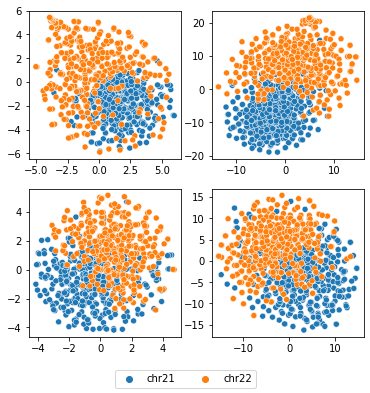

In [19]:
fig, axs = plt.subplots(2,2,figsize=(6,6))
for i,e in enumerate(['uni','bi']):
    for j,o in enumerate(['1st','2nd']):
        data_name = e + '_line_' + o + '_embeddings'
        sns.scatterplot(data=eval(data_name), x = 'tsne1', y = 'tsne2', hue = 'chr_name', ax = axs[i,j])
        axs[i,j].get_legend().remove()
        axs[i,j].set(xlabel = None, ylabel = None)
handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=4, prop={'size': 10})